In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# 1. Data

In [77]:
df_train = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

In [78]:
print(f"Training data set shape: {df_train.shape}, test dataset shape {df_submission.shape}")

Training data set shape: (891, 12), test dataset shape (418, 11)


In [79]:
df_train.head(5).T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [80]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [81]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Let's fill NA with values:

In [82]:
df_train.Age.fillna(df_train.Age.median(), inplace=True)
df_submission.Age.fillna(df_submission.Age.median(), inplace=True)
df_train.Cabin.fillna('XX_unknown', inplace=True)
df_submission.Cabin.fillna('XX_unknown', inplace=True)
df_train.Embarked.fillna(df_train.Embarked.mode()[0], inplace=True)
df_submission.Embarked.fillna(df_submission.Embarked.mode()[0], inplace=True)
df_submission.Fare.fillna(df_submission.Fare.median(), inplace=True)

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Some features, visualize, drop unused cols, etc.

In [84]:
df_train['Name_length'] = df_train.Name.str.len()
df_submission['Name_length'] = df_submission.Name.str.len()
df_train['Cabin_letter'] = df_train.Cabin.str[0]
df_submission['Cabin_letter'] = df_submission.Cabin.str[0]

In [85]:
df_train.drop('Ticket', axis=1, inplace=True)
df_submission.drop('Ticket', axis=1, inplace=True)
df_train.drop('PassengerId', axis=1, inplace=True)
#df_submission.drop('PassengerId', axis=1, inplace=True)
df_train.drop('Name', axis=1, inplace=True)
df_submission.drop('Name', axis=1, inplace=True)
#df_train.drop('Cabin', axis=1, inplace=True)
#df_submission.drop('Cabin', axis=1, inplace=True)

In [86]:
df_train.head(5).T

,0,1,2,3,4
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Fare,7.25,71.2833,7.925,53.1,8.05
Cabin,XX_unknown,C85,XX_unknown,C123,XX_unknown
Embarked,S,C,S,S,S
Name_length,23,51,22,44,24


In [87]:
df_train_label_enc = df_train.copy()
df_sub_label_enc = df_submission.copy()
df_train_label_enc.drop('Cabin', axis=1, inplace=True)
df_sub_label_enc.drop('Cabin', axis=1, inplace=True)
labelencoder = LabelEncoder()
df_train_label_enc.Sex = labelencoder.fit_transform(df_train_label_enc.Sex)
df_sub_label_enc.Sex = labelencoder.transform(df_sub_label_enc.Sex)
df_train_label_enc.Embarked = labelencoder.fit_transform(df_train_label_enc.Embarked)
df_sub_label_enc.Embarked = labelencoder.transform(df_sub_label_enc.Embarked)
df_train_label_enc.Cabin_letter = labelencoder.fit_transform(df_train_label_enc.Cabin_letter)
df_sub_label_enc.Cabin_letter = labelencoder.transform(df_sub_label_enc.Cabin_letter)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

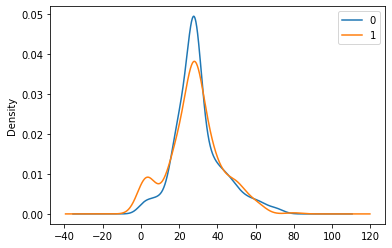

In [88]:
df_train_label_enc.groupby('Survived').Age.plot(kind='kde', legend=True)

In [89]:
train_data_enc, test_data_enc, train_labels_enc, test_labels_enc = train_test_split(
    df_train_label_enc.drop('Survived', axis=1, inplace=False), 
    df_train_label_enc.Survived, 
    test_size=0.25)

### RF as a benchmark 

In [90]:
rfc = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': np.arange(100, 200, 20),
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': np.arange(1, 20),
        'max_depth': np.arange(1, 15),
    },
    n_iter=50,
    n_jobs=-1,
    cv=5,
    verbose=1,
)

In [91]:
rfc.fit(train_data_enc, train_labels_enc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [92]:
rfc.best_params_

{'max_depth': 6,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 180}

In [93]:
rfc.best_score_

0.811377245508982

In [94]:
rfc_test_enc_preds = rfc.predict(test_data_enc)

In [95]:
print(confusion_matrix(test_labels_enc, rfc_test_enc_preds))

[[133  15]
 [ 21  54]]


In [96]:
print(classification_report(test_labels_enc, rfc_test_enc_preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       148
           1       0.78      0.72      0.75        75

    accuracy                           0.84       223
   macro avg       0.82      0.81      0.82       223
weighted avg       0.84      0.84      0.84       223



## NN

In [97]:
train_data_nn, test_data_nn, train_labels_nn, test_labels_nn = train_test_split(
    df_train.drop('Survived', axis=1, inplace=False), 
    df_train.Survived, 
    test_size=0.25)

In [98]:
train_data_nn.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_length,Cabin_letter
348,3,male,3.0,1,1,15.9000,XX_unknown,S,38,X
717,2,female,27.0,0,0,10.5000,E101,S,35,E
556,1,female,48.0,1,0,39.6000,A16,C,65,A
726,2,female,30.0,3,0,21.0000,XX_unknown,S,43,X
765,1,female,51.0,1,0,77.9583,D11,S,36,D


In [99]:
cat_cols = [
    'Pclass',
    'Sex',
    'Cabin',
    'Embarked',
    'Cabin_letter'
]

In [100]:
cont_cols = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Name_length'
]

In [101]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype("category")
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories, start=1))
        df[cat_col] = df[cat_col].cat.codes + 1
    return df, cat_features_map

In [102]:
def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col] = df[cat_col].astype(int)
    return df

In [103]:
def conts_fit_transform(df, cont_cols):
    df = df.copy()
    cont_features_map = {}
    df[cont_cols] = df[cont_cols].astype(float)
    for cont_col in cont_cols:
        cont_features_map[cont_col] = {
            "mean": df[cont_col].mean(),
            "std": df[cont_col].std(),
        }
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df, cont_features_map

In [104]:
def conts_transform(df, cont_features_map):
    df = df.copy()
    for cont_col in cont_features_map:
        df[cont_col] = (
            df[cont_col] - cont_features_map[cont_col]["mean"]
        ) / cont_features_map[cont_col]["std"]
    return df

In [105]:
train_data_nn, cat_features_map = cats_fit_transform(train_data_nn, cat_cols)

In [106]:
train_data_nn.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_length,Cabin_letter
348,3,2,3.0,1,1,15.9000,120,3,38,9
717,2,1,27.0,0,0,10.5000,94,3,35,5
556,1,1,48.0,1,0,39.6000,2,1,65,1
726,2,1,30.0,3,0,21.0000,120,3,43,9
765,1,1,51.0,1,0,77.9583,75,3,36,4


In [107]:
train_data_nn, cont_features_map = conts_fit_transform(train_data_nn, cont_cols)

In [108]:
train_data_nn.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_length,Cabin_letter
348,3,2,-2.074901,0.403932,0.795549,-0.321264,120,3,1.121487,9
717,2,1,-0.222766,-0.477854,-0.478856,-0.436721,94,3,0.806320,5
556,1,1,1.397853,0.403932,-0.478856,0.185462,2,1,3.957997,1
726,2,1,0.008751,2.167504,-0.478856,-0.212222,120,3,1.646767,9
765,1,1,1.629370,0.403932,-0.478856,1.005594,75,3,0.911376,4


In [109]:
test_data_nn = conts_transform(test_data_nn, cont_features_map)

In [110]:
test_data_nn = cats_transform(test_data_nn, cat_features_map)

In [111]:
cat_feature_dims = {cat_col: len(np.unique(train_data_nn[cat_col])) + 2 for cat_col in cat_cols}

In [112]:
def make_embedding_model(
    cat_feature_dims,
    n_cont_features,
    n_classes,
    layer_size,
    dropout_rate=0.0,
    n_layers=1,
    regularization=None,
    batch_norm=True,
):
    inputs = []
    embeddings = []
    
    for cat_feature_dim in cat_feature_dims.values():
        x = tf.keras.layers.Input(shape=(1,))
        inputs.append(x)
        x = tf.keras.layers.Embedding(
            cat_feature_dim,
            np.sqrt(cat_feature_dim).astype(int) + 1,
            input_length=1,
            embeddings_regularizer=tf.keras.regularizers.l1_l2(1e-2, 1e-2),
        )(x)
        x = tf.keras.layers.Flatten()(x)
        embeddings.append(x)
        
    cont_inputs = tf.keras.layers.Input(shape=(n_cont_features,))
    inputs.append(cont_inputs)
    embeddings.append(cont_inputs)
    
    x = tf.keras.layers.Concatenate()(embeddings)
        
    for _ in range(n_layers):
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(
            layer_size,
            kernel_initializer="he_uniform",
            kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
        )(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [113]:
embedding_model = make_embedding_model(
    cat_feature_dims,
    len(cont_cols),
    n_classes=2,
    layer_size=64,
    dropout_rate=0.0,
    n_layers=2,
    regularization=None,
    batch_norm=True,
)

In [114]:
embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
    ],
)

In [115]:
emb_train_data = [train_data_nn[x] for x in train_data_nn[cat_cols]] + [train_data_nn[cont_cols]]
emb_test_data = [test_data_nn[x] for x in test_data_nn[cat_cols]] + [test_data_nn[cont_cols]]

In [116]:
PATIENCE = 10

embedding_model_history = embedding_model.fit(
    emb_train_data,
    train_labels_nn,
    validation_split=0.2,
    batch_size=64,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(str('./embedding_model.h5'), save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(patience=PATIENCE * 3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=str('./embedding_model_logs')),
    ],
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a

Train on 534 samples, validate on 134 samples
Epoch 1/100
534/534 [==============================] - 2s 4ms/sample - loss: 1.0284 - binary_accuracy: 0.6667 - val_loss: 0.9463 - val_binary_accuracy: 0.6642
Epoch 2/100
534/534 [==============================] - 0s 262us/sample - loss: 0.8001 - binary_accuracy: 0.7584 - val_loss: 0.8481 - val_binary_accuracy: 0.6866
Epoch 3/100
534/534 [==============================] - 0s 231us/sample - loss: 0.6719 - binary_accuracy: 0.8202 - val_loss: 0.7939 - val_binary_accuracy: 0.7015
Epoch 4/100
534/534 [==============================] - 0s 228us/sample - loss: 0.5915 - binary_accuracy: 0.8333 - val_loss: 0.7504 - val_binary_accuracy: 0.6866
Epoch 5/100
534/534 [==============================] - 0s 231us/sample - loss: 0.5279 - binary_accuracy: 0.8408 - val_loss: 0.7228 - val_binary_accuracy: 0.6716
Epoch 6/100
534/534 [==============================] - 0s 227us/sample - loss: 0.4933 - binary_accuracy: 0.8521 - val_loss: 0.7034 - val_binary_accurac

534/534 [==============================] - 0s 240us/sample - loss: 0.2900 - binary_accuracy: 0.9064 - val_loss: 0.6242 - val_binary_accuracy: 0.7463
Epoch 52/100
534/534 [==============================] - 0s 221us/sample - loss: 0.2724 - binary_accuracy: 0.9045 - val_loss: 0.6216 - val_binary_accuracy: 0.7463
Epoch 53/100
534/534 [==============================] - 0s 209us/sample - loss: 0.2884 - binary_accuracy: 0.8989 - val_loss: 0.6200 - val_binary_accuracy: 0.7388
Epoch 54/100
534/534 [==============================] - 0s 199us/sample - loss: 0.2905 - binary_accuracy: 0.9026 - val_loss: 0.6181 - val_binary_accuracy: 0.7463
Epoch 55/100
534/534 [==============================] - 0s 217us/sample - loss: 0.2879 - binary_accuracy: 0.8951 - val_loss: 0.6170 - val_binary_accuracy: 0.7463
Epoch 56/100
534/534 [==============================] - 0s 111us/sample - loss: 0.2896 - binary_accuracy: 0.9026 - val_loss: 0.6184 - val_binary_accuracy: 0.7463
Epoch 57/100
534/534 [===================

In [117]:
def plot_history(history, contains, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

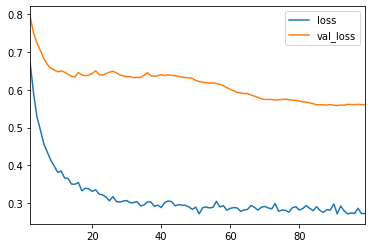

In [118]:
plot_history(embedding_model_history, 'loss', 2)

In [119]:
embedding_model.evaluate(emb_test_data, test_labels_nn)

223/223 [==============================] - 0s 2ms/sample - loss: 0.4058 - binary_accuracy: 0.8386


[0.40584369464840053, 0.83856505]

# Submission

In [120]:
def prepare_submission(preds):
    submission = pd.DataFrame()
    submission['PassengerId'] = df_submission.PassengerId
    submission['Survived'] = preds
    return submission

In [121]:
rfc_sub = prepare_submission(rfc.predict(df_sub_label_enc.drop('PassengerId', ax

In [122]:
rfc_sub.to_csv('rfc.csv', index=False)